In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
# from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [3]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## Utilities

From Exercise 03, re-use the training loop. In addition, we provide you the following function for evaluating the classification accuracy of a pytorch classifier.

In [4]:
def evaluate_classification(model: nn.Module, criterion: nn.modules.loss._Loss, test_loader: DataLoader):

    """
        Evaluates a classification model by computing loss and classification accuracy on a test set.

        Parameters:
        -----------
        model : pytorch model.
        test_loader : pytorch Dataloader containing the test data.
        criterion: Loss function.

    """

    model.eval()

    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)

    return val_loss, accuracy



In [5]:
def train(model:nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
    """
        Basic training loop for a pytorch model.

        Parameters:
        -----------
        model : pytorch model.
        train_loader : pytorch Dataloader containing the training data.
        optimizer: Optimizer for gradient descent. 
        criterion: Loss function. 

    """
        
    # Set model to training mode
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)

    # Loop over each batch from the training set
    for (data, target) in train_loader:
    
        # Copy data to device
        data = data.to(DEVICE)
        target = target.to(DEVICE)

        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad() 

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # get gradients
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
        epoch_loss += loss.data.item()

    return epoch_loss / n_batches


# MNIST

### Loading the data

We want to use a common dataset in machine learning, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of hand-written digits. This is already contained in pytorch, so we don't need to generate it ourselfs and can just download it and store it in a DataLoader.

The dataset is contained in the torchvision package, which we can add to our environment using 

 conda install -c pytorch torchvision 

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [7]:
batch_size = 32

train_dataset_full = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

test_dataset_full = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

# The full dataset contains 60000 samples - this is too much for this Exercise. We therefore choose a subset of 1000 samples randomly chosen.
n_samples_train = 1000

 # get indices for training and test set
ids = np.arange(len(train_dataset_full))
np.random.shuffle(ids)
train_dataset = Subset(train_dataset_full, ids[:n_samples_train])

# get indices for training and test set
n_samples_test = 200
ids = np.arange(len(test_dataset_full))
np.random.shuffle(ids)
test_dataset = Subset(test_dataset_full, ids[:n_samples_test])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("The length of train data is:",len(train_dataset))
print("The length of test data is:",len(test_dataset))


The length of train data is: 1000
The length of test data is: 200


Let's have a look at a few samples from the training dataset.

In [8]:
# pltsize=1
# plt.figure(figsize=(10*pltsize, pltsize))

# for i, idata in enumerate(train_dataset.indices[:10]):

#     image = train_dataset.dataset[idata][0]
#     label =  train_dataset.dataset[idata][1]
    
#     plt.subplot(1,10,i+1)
#     plt.axis('off')
#     plt.imshow(image.numpy().reshape(28,28), cmap="gray_r")
#     plt.title('Class: '+str(label))



## MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, n_units: list, activation= nn.ReLU()):
        """
            Simple multi-layer perceptron (MLP).

            Parameters:
            -----------
            n_units : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 


            Example:
            -----------

            dim_hidden = 100
            dim_in = 2
            dim_out = 5

            # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
            model = MLP([dim_in,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []

        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_units) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
            MLP forward pass

        """
        return self._layers(x)
    
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Epoch 1/20, Train Loss: 2.1411, Test Loss: 1.8842, Test Accuracy: 48.50%
Epoch 2/20, Train Loss: 1.5223, Test Loss: 1.1274, Test Accuracy: 68.50%
Epoch 3/20, Train Loss: 0.8937, Test Loss: 0.7215, Test Accuracy: 79.50%
Epoch 4/20, Train Loss: 0.6221, Test Loss: 0.5738, Test Accuracy: 81.50%
Epoch 5/20, Train Loss: 0.4844, Test Loss: 0.4909, Test Accuracy: 86.00%
Epoch 6/20, Train Loss: 0.4167, Test Loss: 0.4338, Test Accuracy: 88.00%
Epoch 7/20, Train Loss: 0.3414, Test Loss: 0.4105, Test Accuracy: 87.00%
Epoch 8/20, Train Loss: 0.3005, Test Loss: 0.3765, Test Accuracy: 88.00%
Epoch 9/20, Train Loss: 0.2604, Test Loss: 0.3713, Test Accuracy: 89.00%
Epoch 10/20, Train Loss: 0.2294, Test Loss: 0.3727, Test Accuracy: 90.00%
Epoch 11/20, Train Loss: 0.2033, Test Loss: 0.3579, Test Accuracy: 88.00%
Epoch 12/20, Train Loss: 0.1809, Test Loss: 0.3522, Test Accuracy: 89.00%
Epoch 13/20, Train Loss: 0.1651, Test Loss: 0.3635, Test Accuracy: 89.00%
Epoch 14/20, Train Loss: 0.1429, Test Loss: 0.3

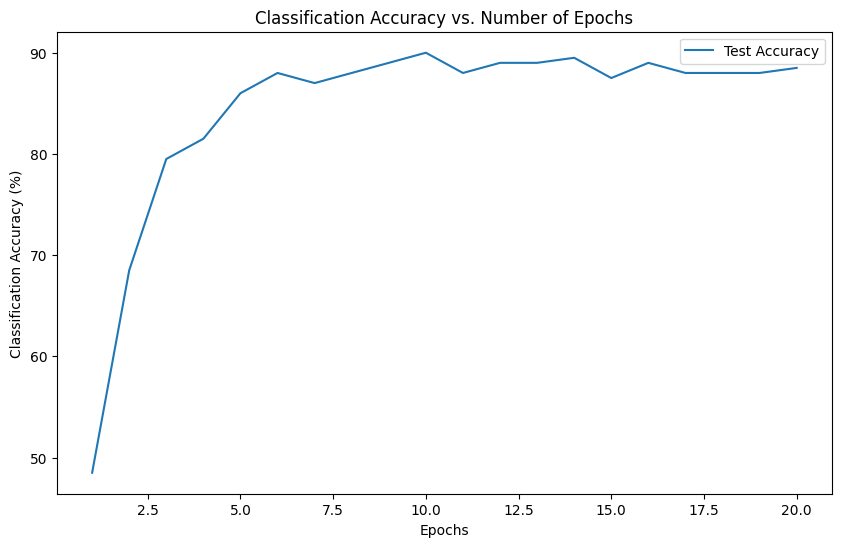

In [10]:
# Define MLPClassifier
class MLPClassifier(MLP):
    def __init__(self, n_units: list, activation=nn.ReLU()):
        super().__init__(n_units, activation)
        
        # Add a flatten layer at the beginning of the layers sequence
        #layers are replaced by flatten an image to vector
        self._layers = nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1), *self._layers)

# Define dimensions for the MLP classifier
input_dim = 28 * 28  # Flattened image size
output_dim = 10  # Number of classes (digits 0-9)
hidden_dim = 40  # Hidden layer size
n_units = [input_dim, hidden_dim, hidden_dim, output_dim]  # 2 hidden layers of size 40

# Create an instance of the MLPClassifier
model = MLPClassifier(n_units).to(DEVICE)

# Use CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
n_epochs = 20
train_losses, test_accuracies = [], []

for epoch in range(n_epochs):
    # Train the model
    train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    # Evaluate the model on the test set
    test_loss, accuracy = evaluate_classification(model, criterion, test_loader)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Plot classification accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Classification Accuracy (%)")
plt.title("Classification Accuracy vs. Number of Epochs")
plt.legend()
plt.show()


## CNN
Here is an idea of how to structure the CNN

In [11]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        out_chanels,
        kernel_size,
        kernel_size_max_pool,
        stride,
        padding,
    ):
        super(CNN, self).__init__()

        self.conv1 = ...  # Fill block

        self.conv2 = ...  # Fill block

        self.linear = ...  # Fill block

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # flattens the output of conv2 to (batch_size, *)
        output = self.linear(x)

        return output

**nn.Conv2d and nn.MaxPool2d in PyTorch affects the dimensions of inputs and outputs**

**1. 2D Convolution (nn.Conv2d)**

The nn.Conv2d layer applies a set of filters (also called kernels) to an input image, producing an output feature map that captures local spatial patterns in the input. Each filter "slides" over the input, performing element-wise multiplications followed by summation, and produces one output channel.
The output height (`H_out`) and width (`W_out`) of a convolutional layer are given by:

`H_out = ((H_in + 2 * padding - kernel_size) / stride) + 1`

`W_out = ((W_in + 2 * padding - kernel_size) / stride) + 1`


**2. 2D Max Pooling (nn.MaxPool2d)**

The nn.MaxPool2d reduces the spatial dimensions of the input by taking the maximum value in each specified window. Pooling helps reduce computational complexity and makes the model more robust by focusing on the most salient features.
The output height (`H_out`) and width (`W_out`) of a convolutional layer are given by:

`H_out = ((H_in + 2 * padding - kernel_size) / stride) + 1`

`W_out = ((W_in + 2 * padding - kernel_size) / stride) + 1`


### Define CNN and MLP classes

In [20]:
# Check for GPU availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')


# Define the CNN model as per instructions
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, kernel_size=5, kernel_size_max_pool=2, stride=1, padding=2):
        super(CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_max_pool)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_max_pool)
        )
        
        # Linear layer to map the output to 10 classes
        self.linear = nn.Linear(out_channels * 7 * 7, 10)  
        # Assuming input images are 28x28 (MNIST size), 2x2 kernel size reduces to 7x7
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten for the linear layer
        output = self.linear(x)
        return output

# Define the MLP model for comparison
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 128) #linear layer1:i/p features(16*7*7=784)
        self.fc2 = nn.Linear(128, 64)  #linear layer2:i/p features(128 fm layer1 o/p)
        self.fc3 = nn.Linear(64, 10)   #128 and 64 are common choices for small-to-medium-sized networks
        self.relu = nn.ReLU()          #Final layer is 10 for MNIST data (10 classes neurons)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

Using device: cpu


In [21]:
# Training both MLP n CNN here
def train(model, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# Evaluation function for both models
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).item() #criterion using CSE loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

# Load MNIST dataset
transform = transforms.ToTensor()
batch_size = 32

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

#For experimentation with parameters using.random.choice() for test,train indices
train_indices = np.random.choice(len(train_dataset), 1000, replace=False)
test_indices = np.random.choice(len(test_dataset), 200, replace=False)

#using subset here for faster experimentation
train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(test_dataset, test_indices), batch_size=batch_size, shuffle=False)

# Define training parameters
learning_rate = 0.001
n_epochs = 10
criterion = nn.CrossEntropyLoss()

# Initialize and train MLP
mlp_model = MLP().to(DEVICE)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)

print("Training MLP model...")
for epoch in range(1, n_epochs + 1):
    train_loss = train(mlp_model, train_loader, mlp_optimizer, criterion)
    test_loss, accuracy = evaluate(mlp_model, test_loader, criterion)
    print(f'MLP Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Accuracy = {accuracy:.2f}%')

# Initialize and train CNN
cnn_model = CNN().to(DEVICE)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

print("\nTraining CNN model...")
for epoch in range(1, n_epochs + 1): #for epoch from 1 to n_epoch
    train_loss = train(cnn_model, train_loader, cnn_optimizer, criterion)
    test_loss, accuracy = evaluate(cnn_model, test_loader, criterion)
    print(f'CNN Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Accuracy = {accuracy:.2f}%')

# Count the number of trainable parameters using sum() fm mlp,cnn_model
mlp_params_count = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
cnn_params_count = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters in MLP model: {mlp_params_count}')
print(f'Trainable parameters in CNN model: {cnn_params_count}')


Training MLP model...
MLP Epoch 1: Train Loss = 1.9505, Test Loss = 1.3439, Accuracy = 71.00%
MLP Epoch 2: Train Loss = 0.9276, Test Loss = 0.6281, Accuracy = 83.50%
MLP Epoch 3: Train Loss = 0.5103, Test Loss = 0.4715, Accuracy = 84.50%
MLP Epoch 4: Train Loss = 0.3894, Test Loss = 0.4208, Accuracy = 87.50%
MLP Epoch 5: Train Loss = 0.3100, Test Loss = 0.3993, Accuracy = 87.50%
MLP Epoch 6: Train Loss = 0.2345, Test Loss = 0.3801, Accuracy = 88.50%
MLP Epoch 7: Train Loss = 0.1982, Test Loss = 0.3583, Accuracy = 88.50%
MLP Epoch 8: Train Loss = 0.1696, Test Loss = 0.3974, Accuracy = 85.50%
MLP Epoch 9: Train Loss = 0.1478, Test Loss = 0.4104, Accuracy = 87.50%
MLP Epoch 10: Train Loss = 0.1086, Test Loss = 0.3983, Accuracy = 86.50%

Training CNN model...
CNN Epoch 1: Train Loss = 2.0114, Test Loss = 1.2878, Accuracy = 66.50%
CNN Epoch 2: Train Loss = 0.8040, Test Loss = 0.5859, Accuracy = 79.00%
CNN Epoch 3: Train Loss = 0.4805, Test Loss = 0.4248, Accuracy = 84.50%
CNN Epoch 4: Train

Conclusions from results:
1. CNN outperforms MLP in accuracy (92%) for 10 epochs
2. CNN better suited for images to learn features like edges, textures. MLP treats each pix. as features so it can’t capture complex spatial features properly.
3. MLP (109386) has more parameters over CNN (14682) due to convolutional layers of image data. CNN learn data efficiently over image reducing overfitting and more efficient for image data.